# Supervised Learning Use Case: Predicting Housing Prices

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn 
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import preprocessing
np.set_printoptions(suppress=True)
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

#### Referenced Resources: 
1. Categorical encoding: http://pbpython.com/categorical-encoding.html


## Read in Data

In [3]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

In [4]:
# Preview Data
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,nan,SS,Jellis,3/09/2016,2.500,3067.000,...,1.000,1.000,126.000,nan,nan,Yarra City Council,-37.801,144.996,Northern Metropolitan,4019.000
1,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,...,1.000,1.000,202.000,nan,nan,Yarra City Council,-37.800,144.998,Northern Metropolitan,4019.000
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,...,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
3,Abbotsford,18/659 Victoria St,3,u,nan,VB,Rounds,4/02/2016,2.500,3067.000,...,2.000,1.000,0.000,nan,nan,Yarra City Council,-37.811,145.012,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,...,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000


In [5]:
# Evaluate where missing values are
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [6]:
# Review missing columns with significant missing values
df.drop(['Landsize','BuildingArea','YearBuilt','Lattitude','Longtitude','Address','SellerG'],axis=1,inplace=True)

In [7]:
df = df[np.isfinite(df['Price'])]

In [8]:
# Drop any remaining rows with missing values
df = df.dropna()

In [9]:
# Evaluate data set size
len(df)

20423

## Examine Data

In [10]:
df.head()

,Suburb,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,CouncilArea,Regionname,Propertycount
1,Abbotsford,2,h,1480000.000,S,3/12/2016,2.500,3067.000,2.000,1.000,1.000,Yarra City Council,Northern Metropolitan,4019.000
2,Abbotsford,2,h,1035000.000,S,4/02/2016,2.500,3067.000,2.000,1.000,0.000,Yarra City Council,Northern Metropolitan,4019.000
4,Abbotsford,3,h,1465000.000,SP,4/03/2017,2.500,3067.000,3.000,2.000,0.000,Yarra City Council,Northern Metropolitan,4019.000
5,Abbotsford,3,h,850000.000,PI,4/03/2017,2.500,3067.000,3.000,2.000,1.000,Yarra City Council,Northern Metropolitan,4019.000
6,Abbotsford,4,h,1600000.000,VB,4/06/2016,2.500,3067.000,3.000,1.000,2.000,Yarra City Council,Northern Metropolitan,4019.000


In [11]:
# Review data types
df.dtypes

Suburb            object
Rooms              int64
Type              object
Price            float64
Method            object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
CouncilArea       object
Regionname        object
Propertycount    float64
dtype: object

In [12]:
# Date feature may be useful in the model, convert data attribute using Datetimeindex
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df.drop(["Date"],axis=1,inplace=True)
df.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,CouncilArea,Regionname,Propertycount,Month
1,Abbotsford,2,h,1480000.000,S,2.500,3067.000,2.000,1.000,1.000,Yarra City Council,Northern Metropolitan,4019.000,3
2,Abbotsford,2,h,1035000.000,S,2.500,3067.000,2.000,1.000,0.000,Yarra City Council,Northern Metropolitan,4019.000,4
4,Abbotsford,3,h,1465000.000,SP,2.500,3067.000,3.000,2.000,0.000,Yarra City Council,Northern Metropolitan,4019.000,4
5,Abbotsford,3,h,850000.000,PI,2.500,3067.000,3.000,2.000,1.000,Yarra City Council,Northern Metropolitan,4019.000,4
6,Abbotsford,4,h,1600000.000,VB,2.500,3067.000,3.000,1.000,2.000,Yarra City Council,Northern Metropolitan,4019.000,4


In [13]:
# Drop categorical features with significant unique values
df.drop(['Suburb','CouncilArea'],axis=1,inplace=True)

In [14]:
# Convert remaining categorical values to numeric
df = pd.get_dummies(df,columns=["Type","Method","Regionname"],prefix=["type","method","region"])

In [15]:
df.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Propertycount,Month,type_h,...,method_SP,method_VB,region_Eastern Metropolitan,region_Eastern Victoria,region_Northern Metropolitan,region_Northern Victoria,region_South-Eastern Metropolitan,region_Southern Metropolitan,region_Western Metropolitan,region_Western Victoria
1,2,1480000.000,2.500,3067.000,2.000,1.000,1.000,4019.000,3,1,...,0,0,0,0,1,0,0,0,0,0
2,2,1035000.000,2.500,3067.000,2.000,1.000,0.000,4019.000,4,1,...,0,0,0,0,1,0,0,0,0,0
4,3,1465000.000,2.500,3067.000,3.000,2.000,0.000,4019.000,4,1,...,1,0,0,0,1,0,0,0,0,0
5,3,850000.000,2.500,3067.000,3.000,2.000,1.000,4019.000,4,1,...,0,0,0,0,1,0,0,0,0,0
6,4,1600000.000,2.500,3067.000,3.000,1.000,2.000,4019.000,4,1,...,0,1,0,0,1,0,0,0,0,0


## Feature Selection

In [16]:
X = df.drop('Price',axis=1)
y = df['Price']

In [17]:
len(df.columns)

25

### PCA

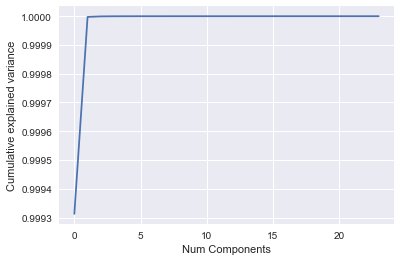

In [18]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative explained variance')

In [19]:
pca.explained_variance_ratio_

array([ 0.99931271,  0.00068479,  0.00000182,  0.00000045,  0.00000011,
        0.00000004,  0.00000002,  0.00000001,  0.00000001,  0.00000001,
        0.00000001,  0.00000001,  0.00000001,  0.00000001,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [20]:
components = 1

## Modeling

In [21]:
# Split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=12)

In [22]:
# Establish number of features to test each time during grid search
features = list(range(1,len(X.columns),3))

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import time

kbest = SelectKBest(mutual_info_regression)


# Construct some pipelines
pipe_lr = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', svm.SVC(random_state=42))])

pipe_knn = Pipeline([('kbest', kbest),
                    ('scl',StandardScaler()),
                    ('clf',KNeighborsClassifier())])

pipe_knn_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', KNeighborsClassifier())])

pipe_nb = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', BernoulliNB())])

pipe_nb_pca = Pipeline([('scl', StandardScaler()),
            ('clf', BernoulliNB())])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'kbest__k': features,
        'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_lr_pca = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_rf = [{'kbest__k': features,
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_rf_pca = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'kbest__k': features,
        'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_svm_pca = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_knn = [{
        'kbest__k': features,
        'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_knn_pca = [{'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_nb = [{'kbest__k':features,
                   'clf__alpha': param_range_fl}]

grid_params_nb_pca = [{'clf__alpha': param_range_fl}]


# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=grid_params_lr_pca,
            scoring='accuracy',
            cv=10)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
            param_grid=grid_params_rf_pca,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
            param_grid=grid_params_svm_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
            param_grid=grid_params_knn_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_nb = GridSearchCV(estimator=pipe_nb,
            param_grid=grid_params_nb,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_nb_pca = GridSearchCV(estimator=pipe_nb_pca,
            param_grid=grid_params_nb_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)



# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca,gs_knn,gs_knn_pca,gs_nb,gs_nb_pca]


# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
        2: 'Random Forest', 3: 'Random Forest w/PCA', 
        4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA', 6: 'K Nearest Neighbors',
            7: 'K Nearest Neighbors w/ PCA', 8: 'Naive Bayes',
            9: 'Naive Bayes w/ PCA'}
    


In [ ]:
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression


/Users/fnkyazn/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
